
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch: 1, Discriminator Loss:  0.3087, Generator Loss:  2.2038
Epoch: 2, Discriminator Loss:  0.1681, Generator Loss:  3.1350
Epoch: 3, Discriminator Loss:  0.2028, Generator Loss:  3.7657
Epoch: 4, Discriminator Loss:  0.1891, Generator Loss:  4.1944
Epoch: 5, Discriminator Loss:  0.1541, Generator Loss:  4.6705
Epoch: 6, Discriminator Loss:  0.1526, Generator Loss:  4.8744
Epoch: 7, Discriminator Loss:  0.1759, Generator Loss:  4.9942
Epoch: 8, Discriminator Loss:  0.1734, Generator Loss:  5.3528
Epoch: 9, Discriminator Loss:  2.4122, Generator Loss: 10.3141
Epoch: 10,

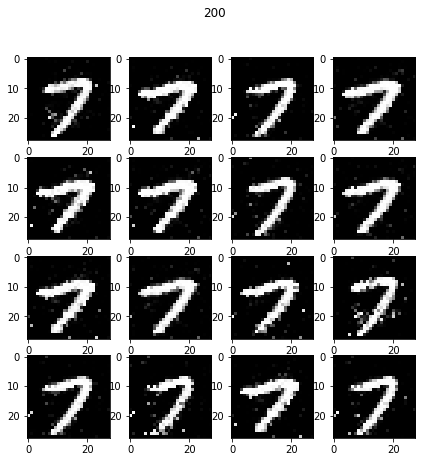

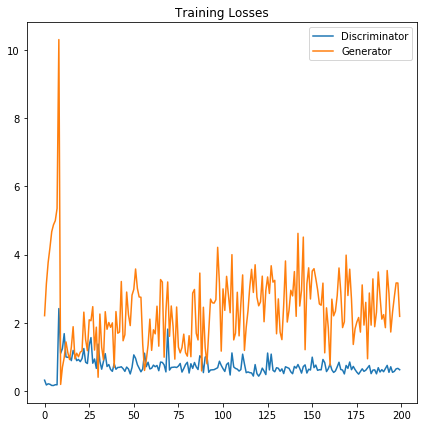

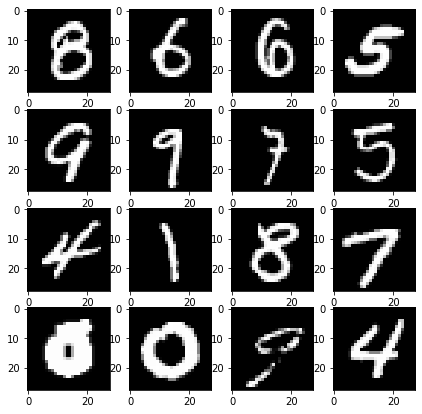

In [1]:
# 필요한 라이브러리 불러들임 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%matplotlib inline

# 그래프 리셋
tf.reset_default_graph() 
# 재현성을 위해 시드 지정
tf.set_random_seed(2)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------

# data load
f1 = open ('./mnist6000/traindata.txt','r')
X0 =[]
X0 =[line.split()for line in f1]
f1.close()
Xvec=np.array(X0, dtype=np.float32)

f1 = open ('./mnist6000/trainlabels.txt','r')
y =[]
y =[line.split()for line in f1]
f1.close()
y=np.array(y, np.int64)

sample_size=Xvec.shape[0] 
Y_onehot=np.zeros((sample_size,10))

# 원-핫 코딩
for ii in range(sample_size):
    Y_onehot[ii, y[ii]]=1

# 입력 변수 수 (=784)    
input_dim = Xvec.shape[1] #=784
# 라벨 정보 변수 수 (=10)    
y_dim=Y_onehot.shape[1] #=10  

#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 입력 잡음신호의 차원: 100
# 미니배치 크기: 100
# 반복 수: 200
# 학습률 : 0.001
# 생성자의 두 은닉층 크기: 128
# 판별자의 두 은닉층 크기: 128

learning_rate = 0.001# 학습률
batch_size = 100 #배치크기
z_size = 100 #잡음크기
nepochs = 200 # epochs
g_hidden_size = 128
d_hidden_size = 128
alpha=0.1 # Leaky ReLu, alpha=0 --> ReLu

# 드롭아웃에서 보존할 노드의 비율 
keep_prob = tf.placeholder(tf.float32,name='keep_prob') # dropout

# 라벨 정보 placeholder
Y = tf.placeholder(tf.float32, shape=[None, y_dim], name='Y')
# 진짜데이터 placeholder
X = tf.placeholder(tf.float32, shape=[None, input_dim], name='X')
# 잡음 placeholder
Z = tf.placeholder(tf.float32, shape=[None, z_size], name='Z')

#판별자에 사용되는 가중치와 편의
D_W1 = tf.get_variable('D_W1',shape=[input_dim+y_dim,d_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]


# 생성에 사용되는 가중치와 편의
G_W1 = tf.get_variable('G_W1',shape=[z_size+y_dim,g_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')
G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,input_dim],initializer=tf.contrib.layers.xavier_initializer())
G_b2 = tf.Variable(tf.zeros(shape=[input_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

#------------------------------------------------
# 생성자 정의: 입력된 진짜 이미지와 유사한 가짜 이미지 생성
#------------------------------------------------
def generator(z,y):
    with tf.variable_scope('generator'):
        zy=tf.concat([z,y],axis=1)
        h1=tf.matmul(zy, G_W1) + G_b1        
        h1 = tf.maximum(alpha*h1, h1) 
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2) 
        return out

#------------------------------------------------
# 판별자 정의: 입력된 진짜 데이터와 가짜 데이터를 정확하게 분류
#------------------------------------------------
def discriminator(x,y):
    with tf.variable_scope('discriminator'):
        xy=tf.concat([x,y],axis=1)
        h1=tf.matmul(xy, D_W1) + D_b1        
        h1 = tf.maximum(alpha*h1, h1)    
        h1=tf.nn.dropout(h1, keep_prob)
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob)
        prob = tf.nn.sigmoid(h2)
        return prob, h2


# 가짜데이터
G = generator(Z,Y)
# D(.|Y). 진짜데이터와 가짜데이터의 조건부 판별망 결과
D_real, D_logit_real = discriminator(X,Y)
D_fake, D_logit_fake = discriminator(G,Y)

#비용함수 
# 판별자는 진짜데이터는 1, 가짜데이터는 0이 되게 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake

# 생성자는 가짜데이터의 판별망 결과가 1이 되게 만들어야 한다
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

#Optimizer
# 판별망을 훈련할 때는  theta_D 만 업데이트 된다.
D_solver = tf.train.AdamOptimizer(learning_rate,beta1=0.1).minimize(D_loss, var_list=theta_D)
# 생성망 훈련할 때는  theta_G 만 업데이트 된다.
G_solver = tf.train.AdamOptimizer(learning_rate,beta1=0.1).minimize(G_loss, var_list=theta_G)

#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())
#samples = []
losses = []
#saver = tf.train.Saver(var_list=theta_G)
for epoch in range(nepochs):
    n_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(n_batch):
        ii=0
        if ii!=n_batch:
            batch_X=Xvec[ii*batch_size:(ii+1)*batch_size]
            batch_Y=Y_onehot[ii*batch_size:(ii+1)*batch_size]              
        else:
            batch_X=Xvec[(ii+1)*batch_size:]           
            batch_Y=Y_onehot[(ii+1)*batch_size:]   
              
        batch_X = batch_X*2 - 1   
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size)) 
        D_loss_curr,_ = sess.run([D_loss,D_solver], feed_dict={X:batch_X, Z: batch_z, Y: batch_Y,keep_prob:0.9})
        G_loss_curr,_ = sess.run([G_loss,G_solver], feed_dict={X:batch_X, Z: batch_z, Y:batch_Y,keep_prob:0.9})    
        losss=D_loss_curr+G_loss_curr
        avg_loss+=losss/n_batch
   
    print('Epoch: {0}, Discriminator Loss: {1:7.4f}, Generator Loss: {2:7.4f}'  .format(epoch+1,D_loss_curr, G_loss_curr))
    losses.append((D_loss_curr, G_loss_curr,avg_loss))        
      # 200 에폭마다 가짜 이미지 그림  
    if (epoch+1)%200==0:
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_size))
        sample_y = np.zeros(shape=[16, y_dim]); sample_y[:,7]=1
        gen_samples = sess.run(G,feed_dict={Z: sample_z,Y:sample_y})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((28,28)), cmap='Greys_r')

# 판별자, 생성자의 비용함수 그림   
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
#plt.plot(losses.T[2], label='Avg Loss')
plt.title("Training Losses")
plt.legend()

   
# 진짜 이미지 그림    
f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(Xvec[ii].reshape(28,28),cmap='Greys_r')